In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943633 entries, 0 to 1943632
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 29.7 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1943628    0.14
1943629    0.14
1943630    0.14
1943631    0.13
1943632    0.13
Name: kWh, Length: 1943633, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1943628    0.14
1943629    0.14
1943630    0.14
1943631    0.13
1943632    0.13
Name: kWh, Length: 1943633, dtype: float64

In [7]:
l=len(conso_data)-1
l

1943632

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943633 entries, 0 to 1943632
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 74.1 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1943628,25713,0.14,25.713,140.007000,47650537603
1943629,25821,0.14,25.821,139.421401,47650563424
1943630,26187,0.14,26.187,137.472792,47650589611
1943631,27026,0.13,27.026,133.205062,47650616637
1943632,26954,0.13,26.954,133.560882,47650643591


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

47650643591000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 16, 36, 632282)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 21, 16, 36, 632282)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:16:58.566282
1         2023-08-21 21:17:20.424282
2         2023-08-21 21:17:42.425282
3         2023-08-21 21:18:04.353282
4         2023-08-21 21:18:26.244282
                     ...            
1943628   2025-02-23 09:32:14.235282
1943629   2025-02-23 09:32:40.056282
1943630   2025-02-23 09:33:06.243282
1943631   2025-02-23 09:33:33.269282
1943632   2025-02-23 09:34:00.223282
Name: dates, Length: 1943633, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:58.566282,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:17:20.424282,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:42.425282,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:18:04.353282,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:26.244282,21/08/23
...,...,...,...,...,...,...,...
1943628,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25
1943629,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25
1943630,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25
1943631,27026,0.13,27.026,133.205062,47650616637,2025-02-23 09:33:33.269282,23/02/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('23/02/25', 23, 2, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'09:34:32'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 1942383 to 1943632
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1250 non-null   int64         
 1   kWh        1250 non-null   float64       
 2   sec        1250 non-null   float64       
 3   Wh         1250 non-null   float64       
 4   cumul(ms)  1250 non-null   int64         
 5   dates      1250 non-null   datetime64[ns]
 6   days       1250 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 78.1+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.553, 3.701, 4.227, 3.687, 3.947, 4.587, 3.737, 3.468, 3.499, 3.707, 3.409, 4.153, 4.227, 3.665, 3.632, 3.638, 3.316, 3.377, 4.059, 4.031, 4.013, 4.105, 3.509, 4.24, 3.968, 3.748, 4.093, 4.62, 4.144, 3.222, 3.171, 3.87, 3.805, 3.077, 3.784, 4.167, 3.612, 3.729, 4.564, 4.315, 4.419, 3.905, 3.445, 4.265, 3.922, 3.769, 3.543, 3.947, 3.769, 3.457, 4.12, 3.389, 3.826, 3.889, 3.595, 3.739, 4.323, 3.256, 3.868, 3.168, 2.06, 2.043, 2.285, 4.088, 3.637, 4.307, 3.63, 3.99, 3.777, 3.693, 4.21, 3.964, 3.804, 3.129, 3.758, 3.585, 3.551, 3.713, 3.674, 3.34, 3.807, 3.253, 3.757, 3.6, 4.058, 3.566, 3.546, 3.669, 4.043, 4.404, 3.926, 4.067, 4.347, 3.825, 3.868, 3.828, 3.788, 3.823, 4.08, 4.41, 3.873, 3.502, 3.677, 3.68, 3.347, 3.831, 3.799, 4.309, 3.528, 4.163, 3.536, 3.943, 4.69, 3.592, 3.586, 3.52, 3.96, 3.867, 4.149, 3.855, 3.835, 3.627, 5.031, 3.792, 3.676, 4.218, 4.262, 4.344, 4.523, 4.146, 3.658, 4.462, 4.707, 4.095, 4.754, 4.496, 3.66, 4.04, 3.913, 3.617, 3.566, 3.956, 3.659, 3.723, 3.626, 3.4

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1943633

In [30]:
period(p=2)

2023-08-22 03:23:12.369282	2023-08-22 10:27:27.989282	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.299876
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.514707
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

1.25

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 1942383 to 1943632
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1250 non-null   int64         
 1   kWh        1250 non-null   float64       
 2   sec        1250 non-null   float64       
 3   Wh         1250 non-null   float64       
 4   cumul(ms)  1250 non-null   int64         
 5   dates      1250 non-null   datetime64[ns]
 6   days       1250 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 78.1+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


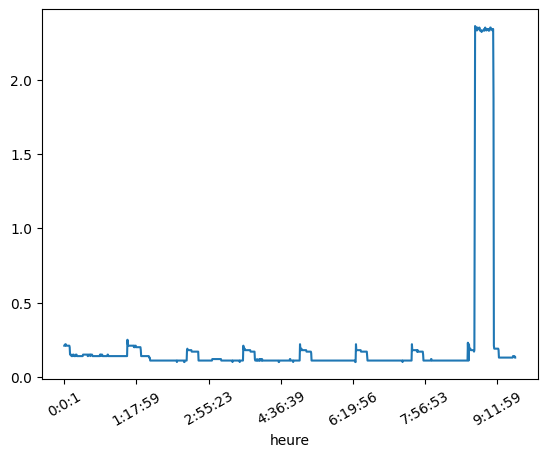

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:58.566282,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:17:20.424282,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:42.425282,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:18:04.353282,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:26.244282,21/08/23
...,...,...,...,...,...,...,...
1943628,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25
1943629,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25
1943630,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25
1943631,27026,0.13,27.026,133.205062,47650616637,2025-02-23 09:33:33.269282,23/02/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:1,17160,0.21,17.160,209.790210,47616204525,2025-02-23 00:00:01.157282,23/02/25
0:0:18,17087,0.21,17.087,210.686487,47616221612,2025-02-23 00:00:18.244282,23/02/25
0:0:35,16957,0.21,16.957,212.301704,47616238569,2025-02-23 00:00:35.201282,23/02/25
0:0:51,16525,0.22,16.525,217.851740,47616255094,2025-02-23 00:00:51.726282,23/02/25
0:1:8,16649,0.22,16.649,216.229203,47616271743,2025-02-23 00:01:08.375282,23/02/25
...,...,...,...,...,...,...,...
9:32:14,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25
9:32:40,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25
9:33:6,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 27/01/25 4.584
Min : 31/01/25 2.817


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1942383,17160,0.21,17.160,209.790210,47616204525,2025-02-23 00:00:01.157282,23/02/25,0:0:1
1942384,17087,0.21,17.087,210.686487,47616221612,2025-02-23 00:00:18.244282,23/02/25,0:0:18
1942385,16957,0.21,16.957,212.301704,47616238569,2025-02-23 00:00:35.201282,23/02/25,0:0:35
1942386,16525,0.22,16.525,217.851740,47616255094,2025-02-23 00:00:51.726282,23/02/25,0:0:51
1942387,16649,0.22,16.649,216.229203,47616271743,2025-02-23 00:01:08.375282,23/02/25,0:1:8
...,...,...,...,...,...,...,...,...
1943628,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25,9:32:14
1943629,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25,9:32:40
1943630,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25,9:33:6
1943631,27026,0.13,27.026,133.205062,47650616637,2025-02-23 09:33:33.269282,23/02/25,9:33:33


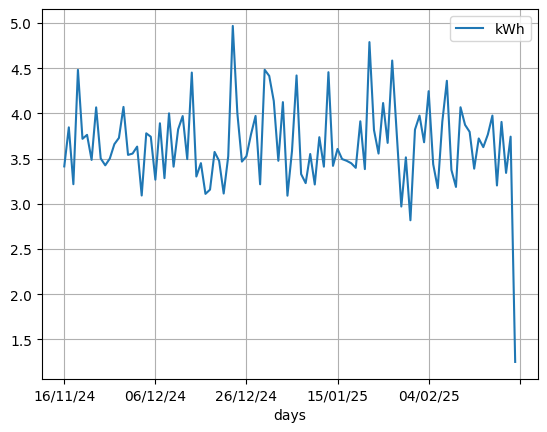

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-02-23 00:00:01.157282	2025-02-23 07:56:20.114282	7h 56m 18s 	1000
2025-02-23 07:56:20.114282	2025-02-23 09:34:00.223282	1h 37m 40s 	250
<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 1942383 to 1943632
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1250 non-null   int64         
 1   kWh        1250 non-null   float64       
 2   sec        1250 non-null   float64       
 3   Wh         1250 non-null   float64       
 4   cumul(ms)  1250 non-null   int64         
 5   dates      1250 non-null   datetime64[ns]
 6   days       1250 non-null   object        
 7   heure      1250 non-null   object        
 8   hours      1250 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 97.7+ KB


('23/02/25', <Axes: xlabel='hours'>)

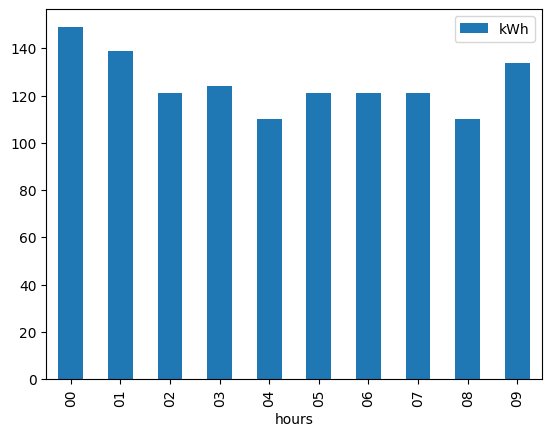

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.553
22/08/23,3.701
23/08/23,4.227
24/08/23,3.687
25/08/23,3.947
...,...
19/02/25,3.202
20/02/25,3.905
21/02/25,3.341


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


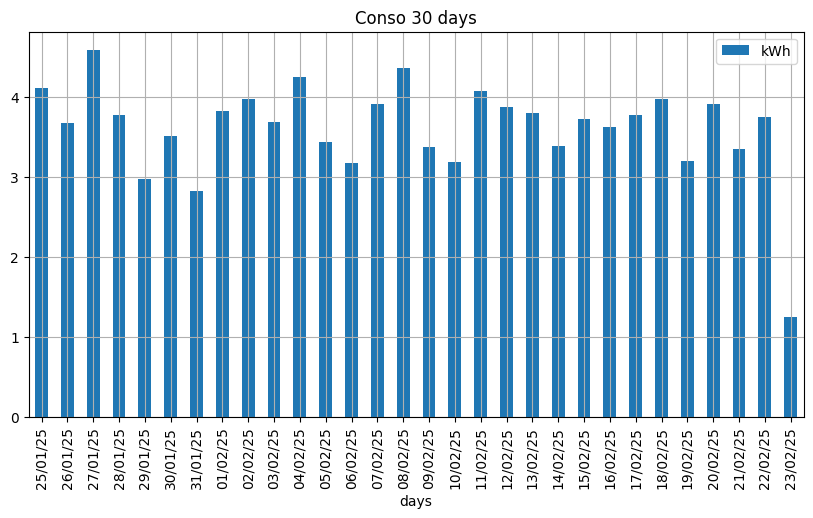

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


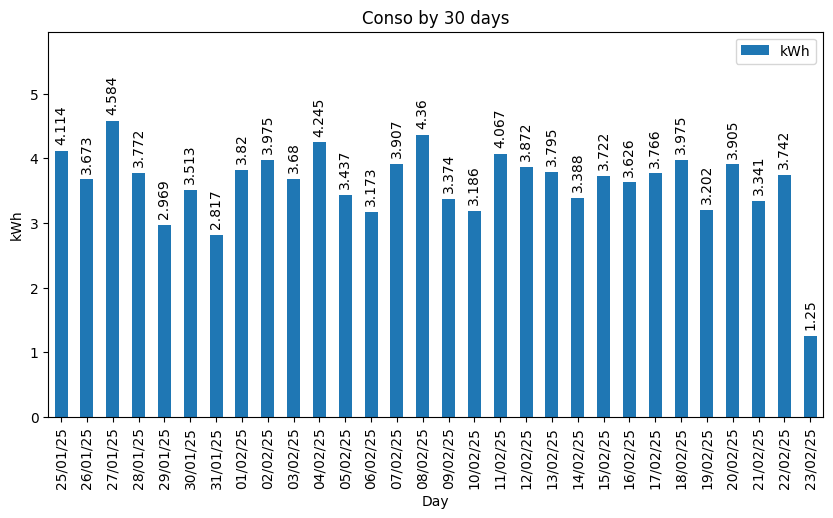

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
25/01/25    4.114
26/01/25    3.673
27/01/25    4.584
28/01/25    3.772
29/01/25    2.969
30/01/25    3.513
31/01/25    2.817
01/02/25    3.820
02/02/25    3.975
03/02/25    3.680
04/02/25    4.245
05/02/25    3.437
06/02/25    3.173
07/02/25    3.907
08/02/25    4.360
09/02/25    3.374
10/02/25    3.186
11/02/25    4.067
12/02/25    3.872
13/02/25    3.795
14/02/25    3.388
15/02/25    3.722
16/02/25    3.626
17/02/25    3.766
18/02/25    3.975
19/02/25    3.202
20/02/25    3.905
21/02/25    3.341
22/02/25    3.742
23/02/25    1.250
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['25/01/25', '26/01/25', '27/01/25', '28/01/25', '29/01/25', '30/01/25',
       '31/01/25', '01/02/25', '02/02/25', '03/02/25', '04/02/25', '05/02/25',
       '06/02/25', '07/02/25', '08/02/25', '09/02/25', '10/02/25', '11/02/25',
       '12/02/25', '13/02/25', '14/02/25', '15/02/25', '16/02/25', '17/02/25',
       '18/02/25', '19/02/25', '20/02/25', '21/02/25', '22/02/25', '23/02/25'],
      dtype='object', name='days')

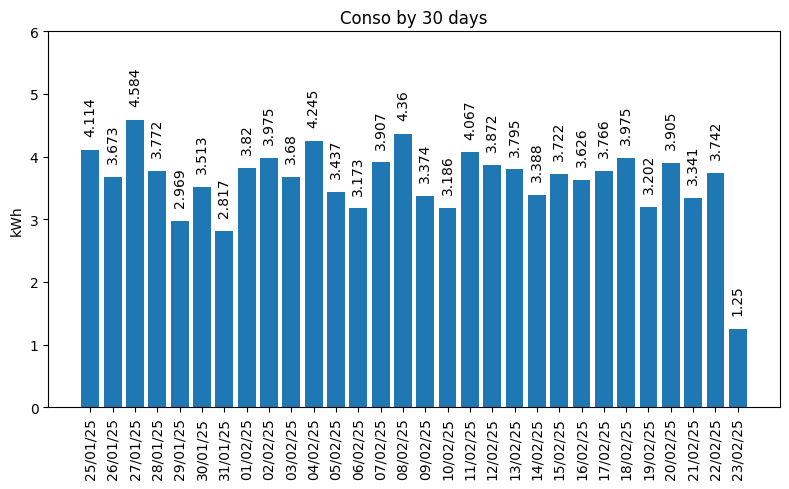

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

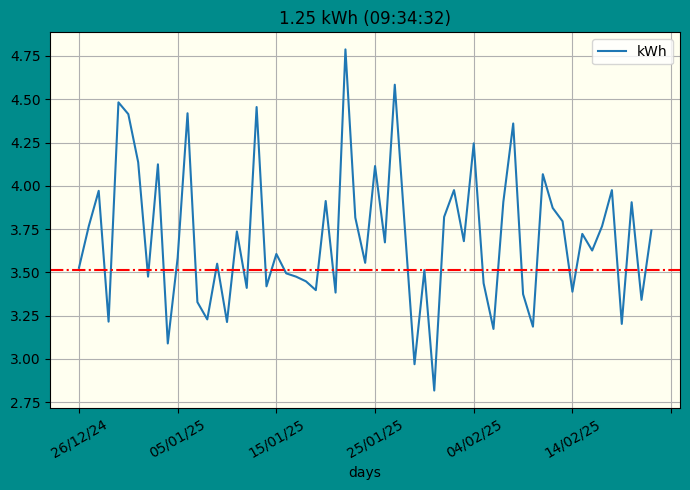

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

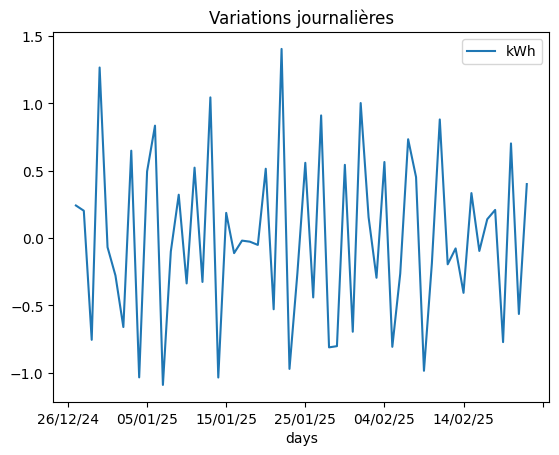

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:58.566282,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:17:20.424282,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:42.425282,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:18:04.353282,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:26.244282,21/08/23,21
...,...,...,...,...,...,...,...,...
1943628,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25,09
1943629,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25,09
1943630,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25,09
1943631,27026,0.13,27.026,133.205062,47650616637,2025-02-23 09:33:33.269282,23/02/25,09


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [55]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,553
22/08/23,3701
23/08/23,4227
24/08/23,3687
25/08/23,3947
...,...
19/02/25,3202
20/02/25,3905
21/02/25,3341


In [56]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:58.566282,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:17:20.424282,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:42.425282,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:18:04.353282,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:26.244282,21/08/23,21
...,...,...,...,...,...,...,...,...
1943628,25713,0.14,25.713,140.007000,47650537603,2025-02-23 09:32:14.235282,23/02/25,09
1943629,25821,0.14,25.821,139.421401,47650563424,2025-02-23 09:32:40.056282,23/02/25,09
1943630,26187,0.14,26.187,137.472792,47650589611,2025-02-23 09:33:06.243282,23/02/25,09
1943631,27026,0.13,27.026,133.205062,47650616637,2025-02-23 09:33:33.269282,23/02/25,09


In [57]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
23/02/25 09    1943628  23/02/25    09  0.14
               1943629  23/02/25    09  0.14
               1943630  23/02/25    09  0.14
               1943631  23/02/25    09  0.13
               1943632  23/02/25    09  0.13

[1943633 rows x 3 columns]

In [58]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [59]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [60]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,553,553
22/08/23,3701,3701
23/08/23,4227,4227
24/08/23,3687,3687
25/08/23,3947,3947
...,...,...
19/02/25,3202,3202
20/02/25,3905,3905
21/02/25,3341,3341


In [61]:
grp_by_day['kWh'].cumsum()

days
21/08/23        553
22/08/23       4254
23/08/23       8481
24/08/23      12168
25/08/23      16115
             ...   
19/02/25    1931395
20/02/25    1935300
21/02/25    1938641
22/02/25    1942383
23/02/25    1943633
Name: kWh, Length: 553, dtype: int64

In [62]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21     133
         22     281
         23     139
22/08/23 00     130
         01     130
...             ...
23/02/25 05     121
         06     121
         07     121
         08     110
         09     134

[13237 rows x 1 columns]

In [63]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21           133
          22           414
          23           553
22/08/23  00           683
          01           813
                    ...   
23/02/25  05       1943147
          06       1943268
          07       1943389
          08       1943499
          09       1943633
Name: kWh, Length: 13237, dtype: int64

In [64]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21     133     133    NaN
         22     281     414  148.0
         23     139     553 -142.0
22/08/23 00     130     130    NaN
         01     130     260    0.0
...             ...     ...    ...
23/02/25 05     121     764   11.0
         06     121     885    0.0
         07     121    1006    0.0
         08     110    1116  -11.0
         09     134    1250   24.0

[13237 rows x 3 columns]

In [65]:
today, grp_by_dayhours.loc[today]

('23/02/25',
        kWh  cumsum  diff
 hours                   
 00     149     149   NaN
 01     139     288 -10.0
 02     121     409 -18.0
 03     124     533   3.0
 04     110     643 -14.0
 05     121     764  11.0
 06     121     885   0.0
 07     121    1006   0.0
 08     110    1116 -11.0
 09     134    1250  24.0)

Text(0.5, 1.0, 'Cumul journalier')

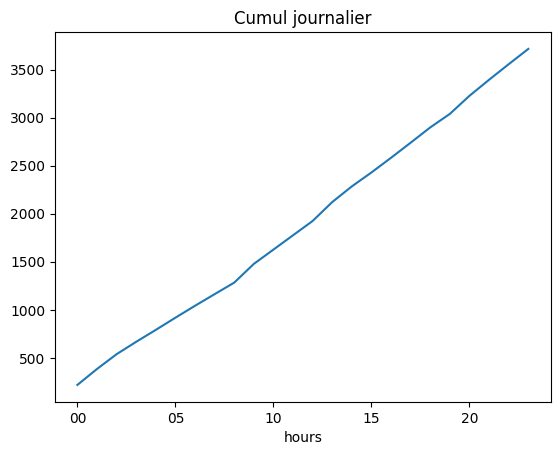

In [66]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

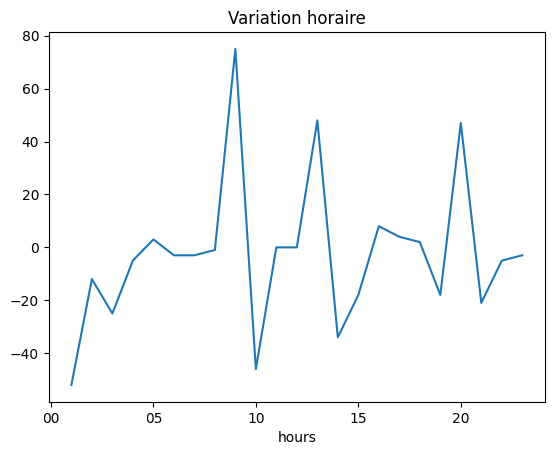

In [67]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [68]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

553

In [69]:
df_grp.tail(n)['kWh'].describe()


count    553.000000
mean       3.514707
std        0.672809
min        0.553000
25%        3.352000
50%        3.627000
75%        3.878000
max        5.031000
Name: kWh, dtype: float64

In [70]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '553 days')

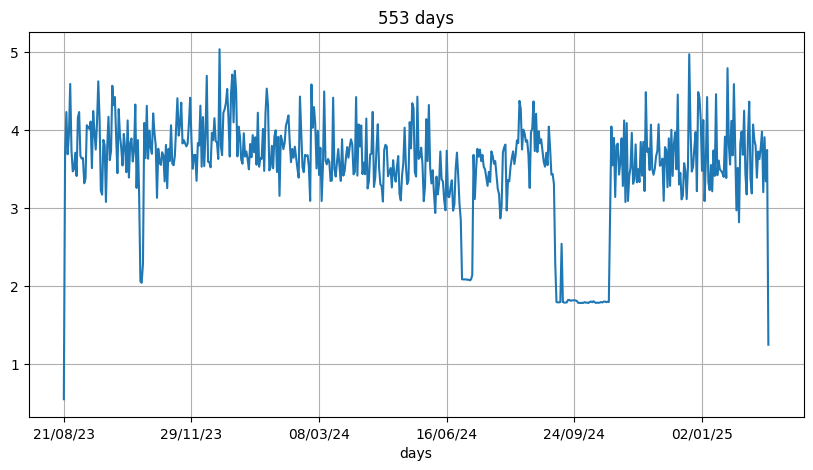

In [71]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

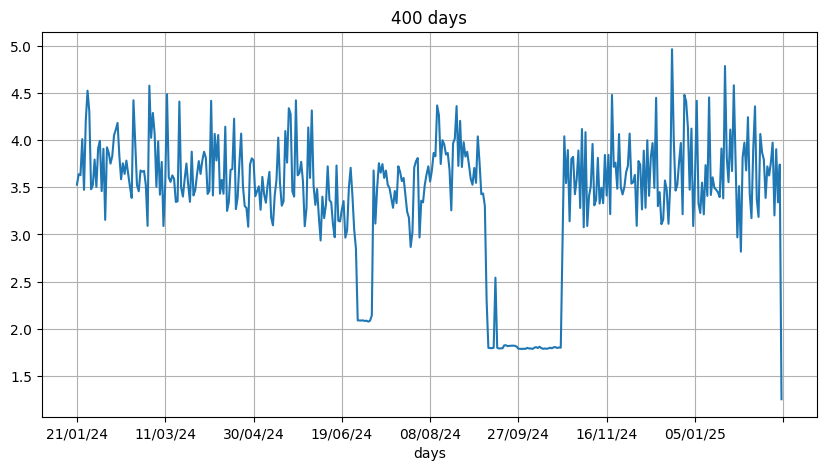

In [72]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [73]:
df_grp['kWh']

days
21/08/23    0.553
22/08/23    3.701
23/08/23    4.227
24/08/23    3.687
25/08/23    3.947
            ...  
19/02/25    3.202
20/02/25    3.905
21/02/25    3.341
22/02/25    3.742
23/02/25    1.250
Name: kWh, Length: 553, dtype: float64

In [74]:
df_grp.describe()

,kWh
count,553.000000
mean,3.514707
std,0.672809
min,0.553000
25%,3.352000
50%,3.627000
75%,3.878000
max,5.031000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

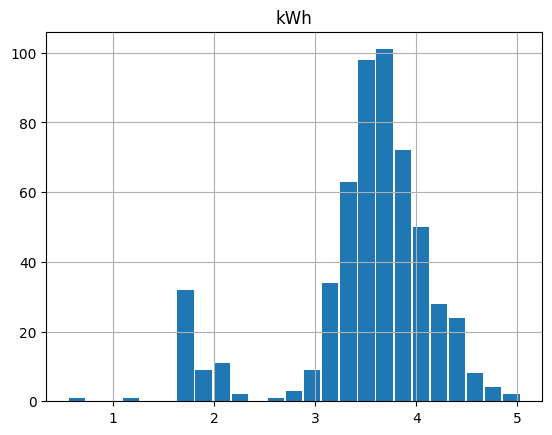

In [75]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [76]:
df_grp.tail(span)['kWh']

days
21/01/24    3.528
22/01/24    3.640
23/01/24    3.629
24/01/24    4.012
25/01/24    3.474
            ...  
19/02/25    3.202
20/02/25    3.905
21/02/25    3.341
22/02/25    3.742
23/02/25    1.250
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [77]:
day

'23/02/25'

In [78]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,149,149,NaN
01,139,288,-10.0
02,121,409,-18.0
03,124,533,3.0
04,110,643,-14.0
05,121,764,11.0
06,121,885,0.0
07,121,1006,0.0
08,110,1116,-11.0


In [79]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [80]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [81]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [82]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [83]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [84]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [85]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [86]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [87]:
day

'23/02/25'

In [88]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,149,149,NaN,1.0
01,139,288,-10.0,2.0
02,121,409,-18.0,3.0
03,124,533,3.0,4.0
04,110,643,-14.0,5.0
05,121,764,11.0,6.0
06,121,885,0.0,7.0
07,121,1006,0.0,8.0
08,110,1116,-11.0,9.0


Text(0.5, 1.0, '23/02/25')

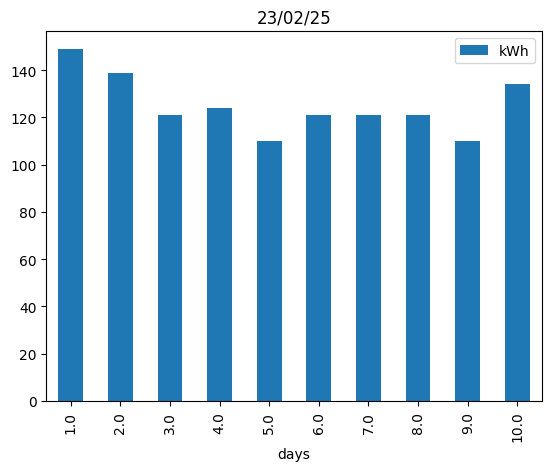

In [89]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [90]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [91]:
groupedbyhour.count()

,kWh
hours,
00,149
01,139
02,121
03,124
04,110
05,121
06,121
07,121
08,110


In [92]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    153
01    164
02    166
03    152
04    170
05    157
06    155
07    142
08    115
09    131
10    129
11    115
12    131
13    114
14    132
15    204
16    139
17    157
18    986
19    206
20    278
21    302
22    312
23    321
Name: kWh, dtype: int64

In [93]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

365.596

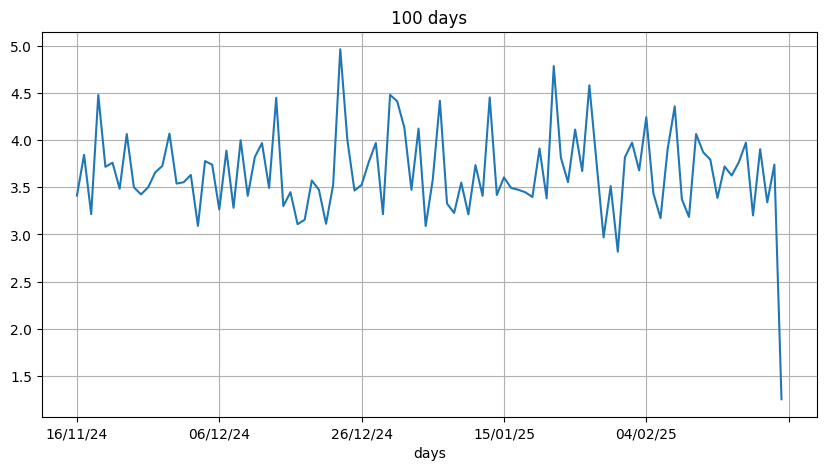

In [94]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [95]:
df_grp.tail(1)

,kWh
days,
23/02/25,1.25


In [96]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

1.25

In [97]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

104.66229367256165


# Today

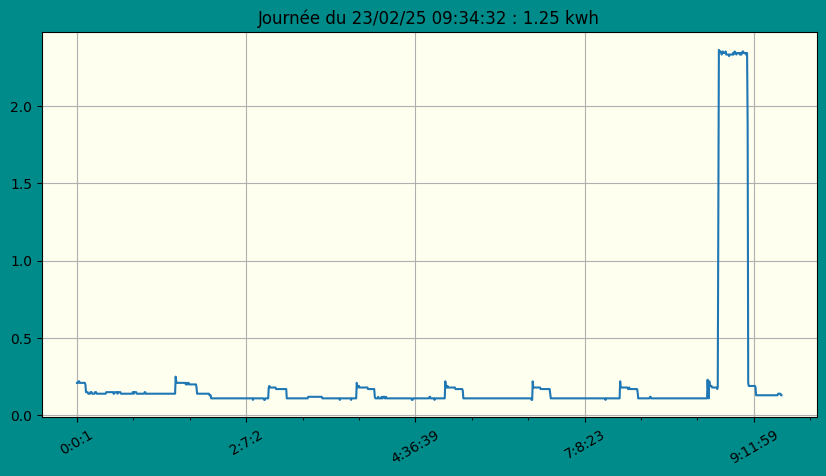

In [98]:
show(today,bgcolor='ivory')

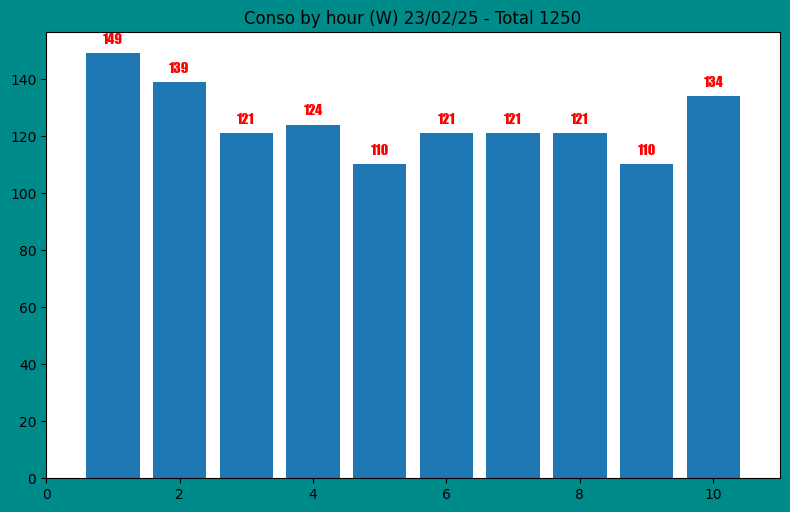

In [99]:
conso_by_hour(today)

In [100]:
day = '16/01/25'

('16/01/25', None)

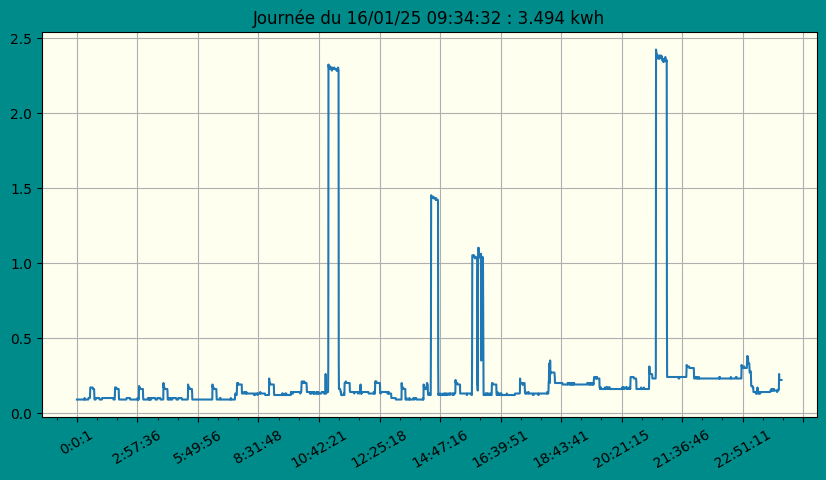

In [101]:
day, show(day,bgcolor='ivory')

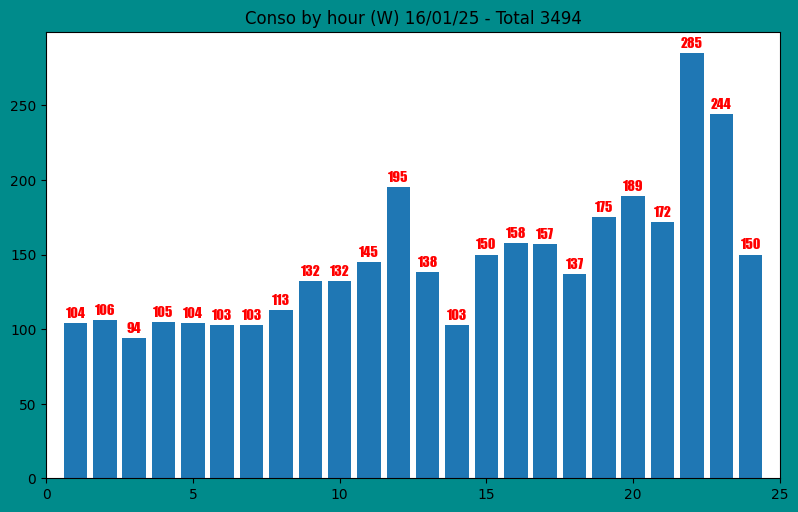

In [102]:
conso_by_hour(day)

In [103]:
maxday

'21/12/23'

('21/12/23', None)

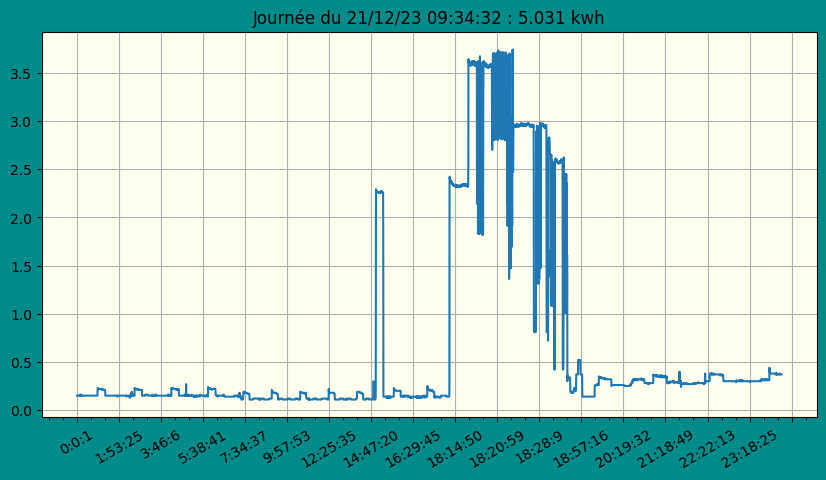

In [104]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

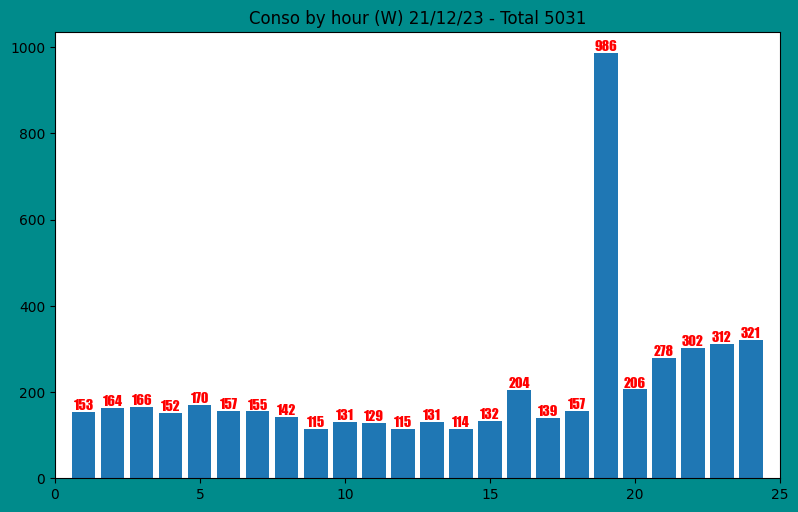

In [105]:
conso_by_hour(day)

In [106]:
sum(data)

5031

In [107]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,149,149,NaN,1.0
01,139,288,-10.0,2.0
02,121,409,-18.0,3.0
03,124,533,3.0,4.0
04,110,643,-14.0,5.0
05,121,764,11.0,6.0
06,121,885,0.0,7.0
07,121,1006,0.0,8.0
08,110,1116,-11.0,9.0


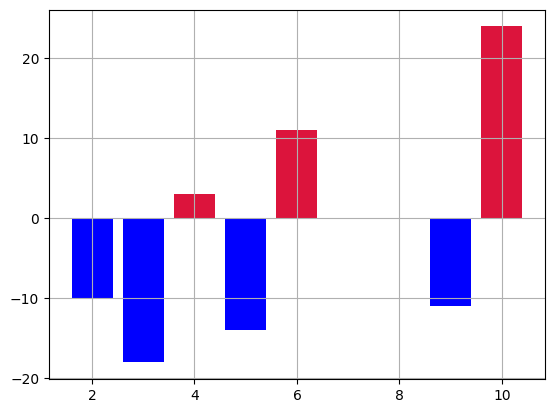

In [108]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [109]:
data

hours
00    153
01    164
02    166
03    152
04    170
05    157
06    155
07    142
08    115
09    131
10    129
11    115
12    131
13    114
14    132
15    204
16    139
17    157
18    986
19    206
20    278
21    302
22    312
23    321
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

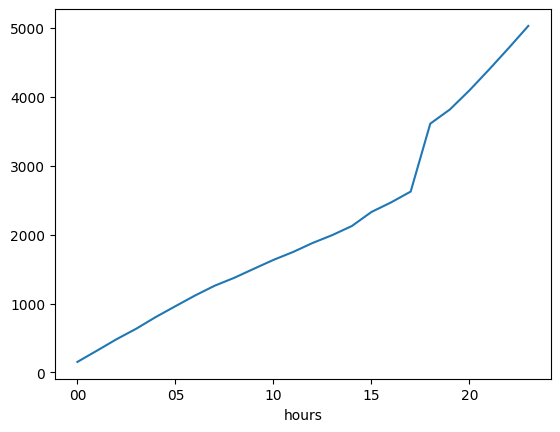

In [110]:
data.cumsum().plot()


<Axes: xlabel='hours'>

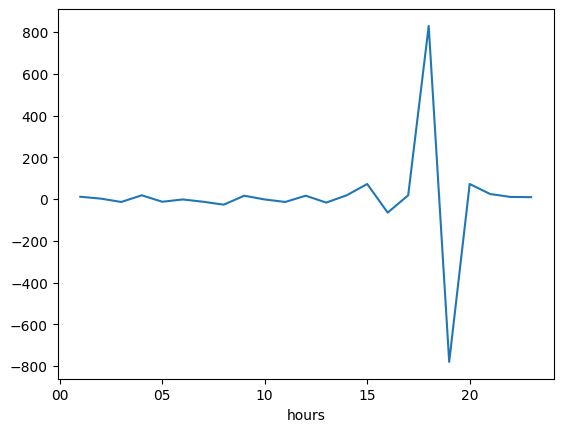

In [111]:
# evolution par heure
data.diff().plot()

In [112]:
data.diff().describe()

count     23.000000
mean       7.304348
std      244.310614
min     -780.000000
25%      -13.500000
50%        9.000000
75%       18.000000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

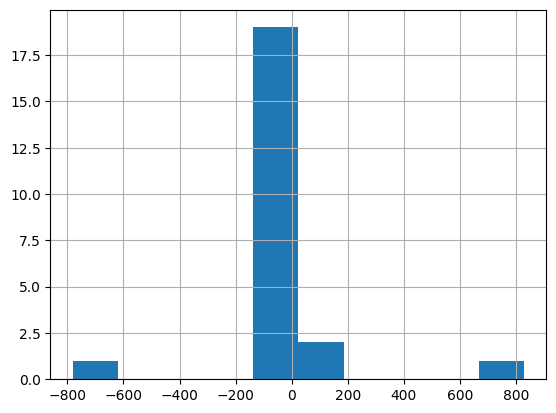

In [113]:
data.diff().hist()

# Test sauvegarde

In [114]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [115]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [116]:
#conso_byhour(day)

In [117]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


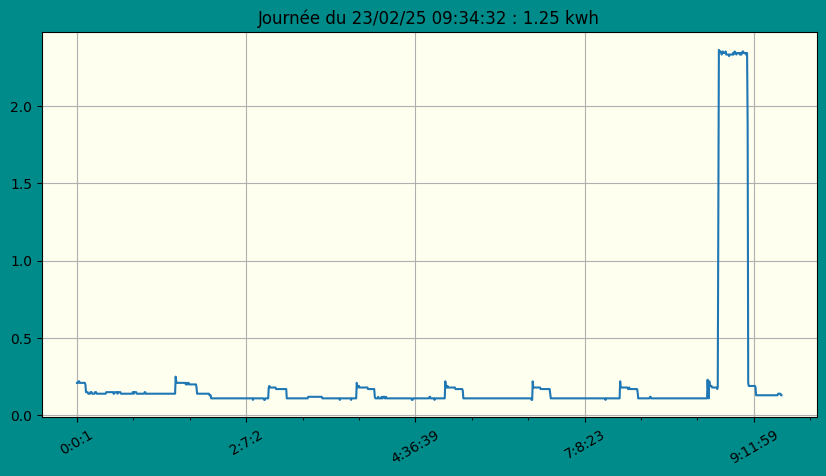

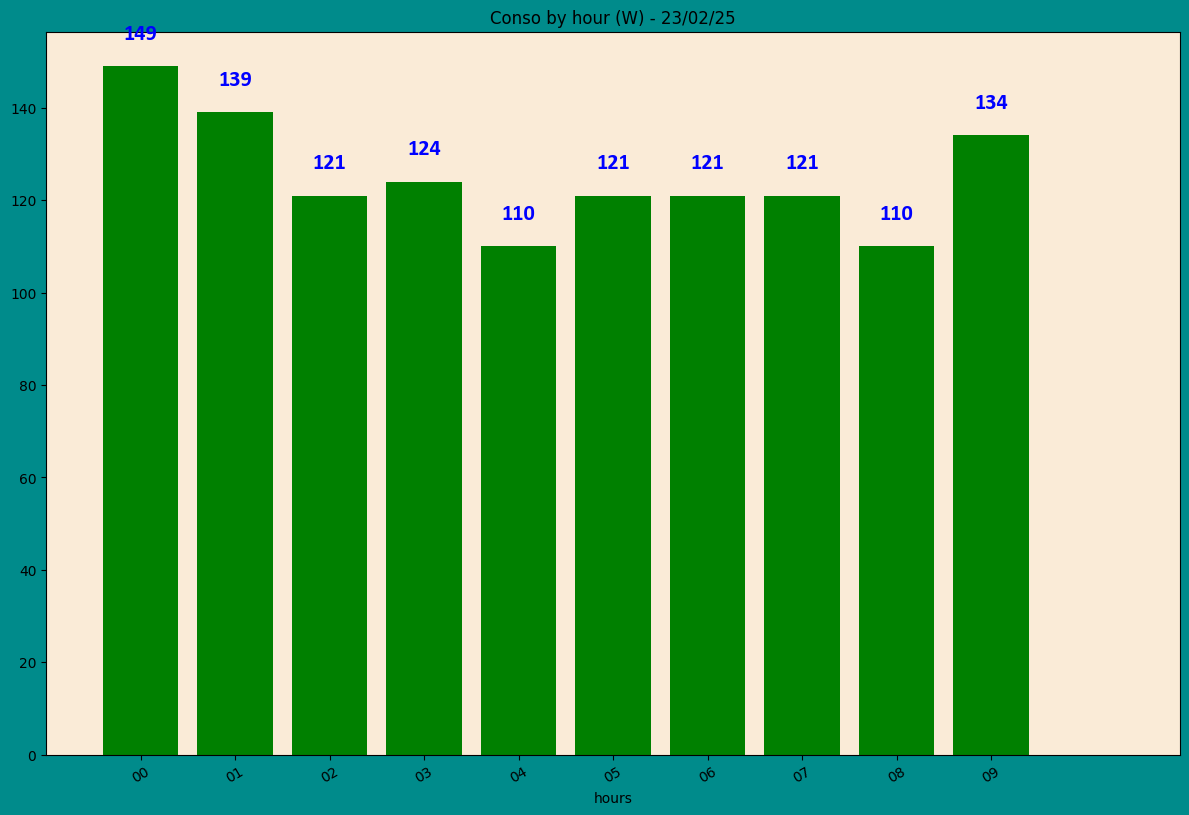

In [118]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [119]:
month.describe()


count    30.000000
mean      3.685167
std       0.401838
min       2.817000
25%       3.400250
50%       3.732000
75%       3.906500
max       4.584000
Name: kWh, dtype: float64

<Axes: >

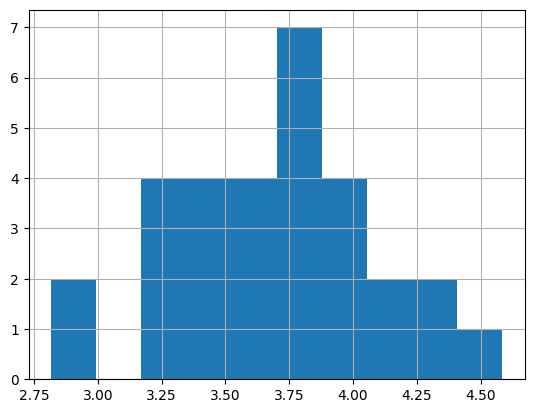

In [120]:
month.hist()

<Axes: xlabel='days'>

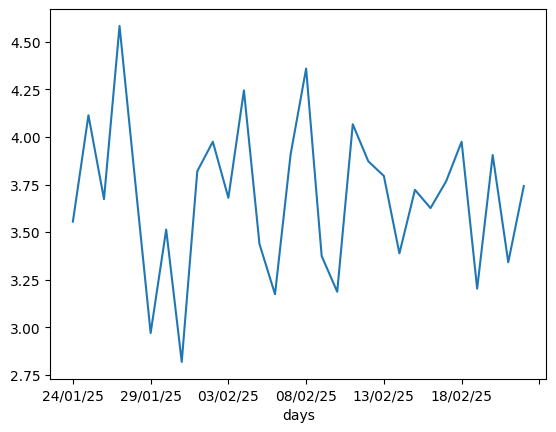

In [121]:
month.plot()

In [122]:
# date with max conso in 1 month
month.idxmax()

'27/01/25'

In [123]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'27/01/25'

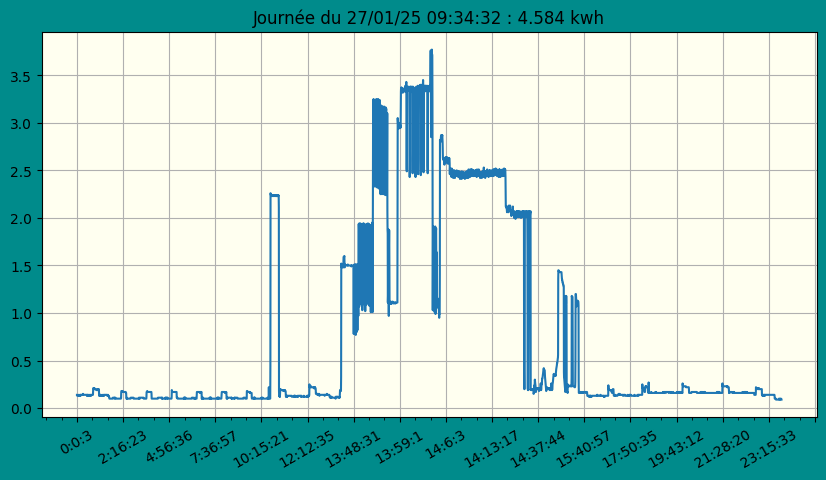

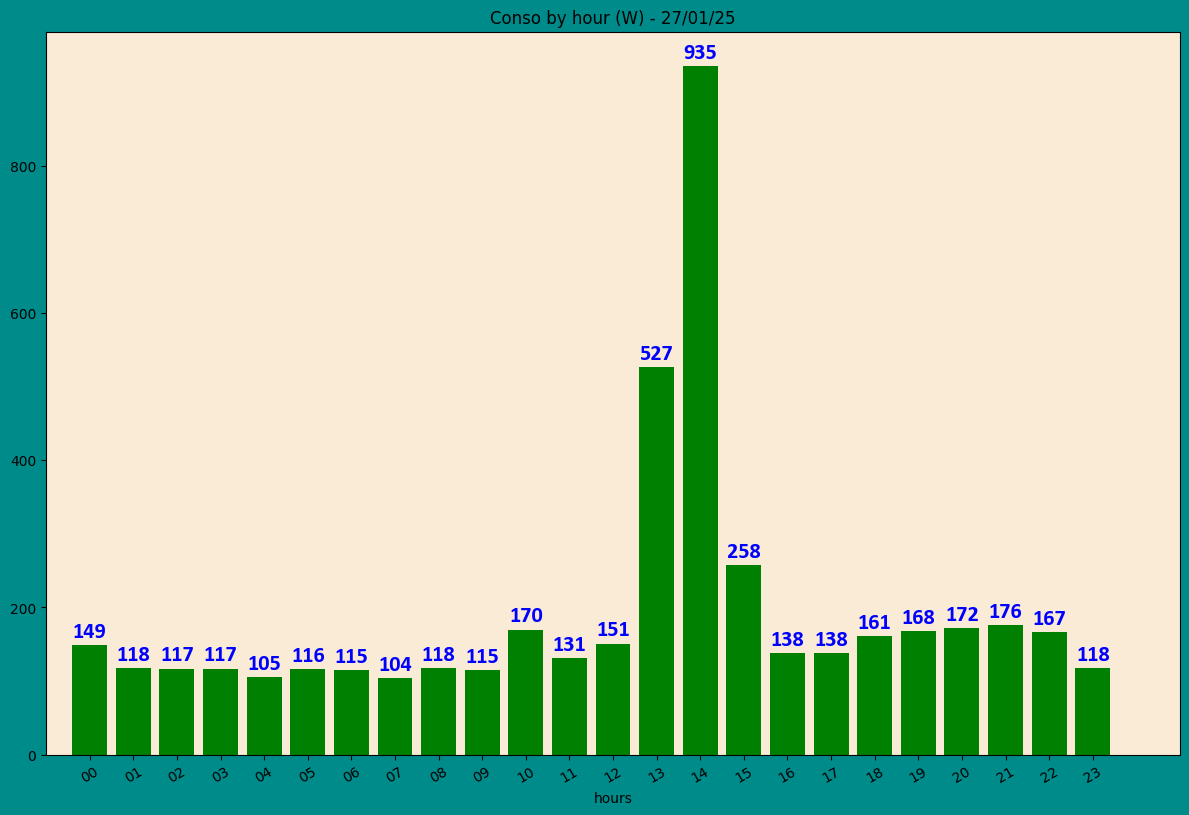

In [124]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [125]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21     133     133    NaN   NaN
         22     281     414  148.0   NaN
         23     139     553 -142.0   NaN
22/08/23 00     130     130    NaN   NaN
         01     130     260    0.0   NaN
...             ...     ...    ...   ...
23/02/25 05     121     764   11.0   6.0
         06     121     885    0.0   7.0
         07     121    1006    0.0   8.0
         08     110    1116  -11.0   9.0
         09     134    1250   24.0  10.0

[13237 rows x 4 columns]

In [126]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,149,149,NaN,NaN
01,118,267,-31.0,NaN
02,117,384,-1.0,NaN
03,117,501,0.0,NaN
04,105,606,-12.0,NaN
05,116,722,11.0,NaN
06,115,837,-1.0,NaN
07,104,941,-11.0,NaN
08,118,1059,14.0,NaN


In [127]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

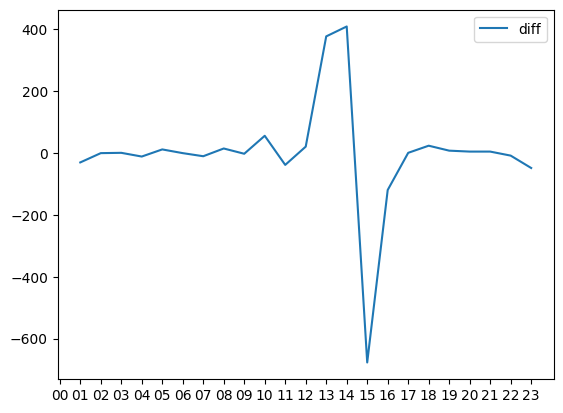

In [128]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

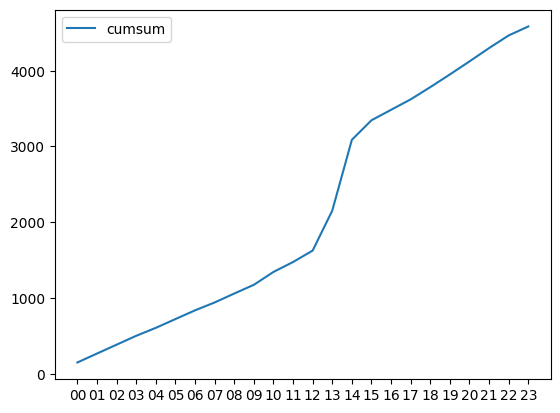

In [129]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [130]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB